In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import spearmanr, gaussian_kde
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch
from torch.nn.functional import normalize
import seaborn as sns
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from multiprocessing import Pool, cpu_count

from tqdm import tqdm
import os

In [2]:
bloom_directory = "../data-bloom"
desai_directory = "../data"

isolated_rbd_bloom = torch.load(f"{bloom_directory}/embeddings_withCoordinates_Isolated_WT_down_state_6xf5.pt")
isolated_rbd_desai = torch.load(f"{desai_directory}/embeddings_withCoordinates_Isolated_WT_down_state_6xf5.pt")

kd_ace_bloom = torch.load(f"{bloom_directory}/logKd_ACE2.pt")
kd_ace_desai = torch.load(f"{desai_directory}/logKd_ACE2.pt")

def normalize_embeddings(embeddings):
    return (embeddings - embeddings.mean(dim=0)) / embeddings.std(dim=0)
# def normalize_kd(kd):
#     return (kd - kd.mean()) / kd.std()

isolated_rbd_bloom = normalize_embeddings(isolated_rbd_bloom)
isolated_rbd_desai = normalize_embeddings(isolated_rbd_desai)

/tmp/ipykernel_1325643/2346811833.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  isolated_rbd_bloom = torch.load(f"{bloom_directory}/embeddings_withCoordinates_Isolated

In [48]:
def get_trained_model(model_class, embeddings, kd_Y, seed, model_kwargs, verbose=False):

    kd_scaler = StandardScaler()
    kd_Y = kd_scaler.fit_transform(kd_Y.reshape(-1, 1)).reshape(-1)

    # Set seed for reproducibility
    np.random.seed(seed)

    # Perform the benchmark
    model = model_class(**model_kwargs)
    model.fit(embeddings, kd_Y)
    predictions = model.predict(embeddings)

    predictions = kd_scaler.inverse_transform(predictions.reshape(-1, 1)).reshape(-1)
    kd_Y = kd_scaler.inverse_transform(kd_Y.reshape(-1, 1)).reshape(-1)

    if verbose:
        # Calculate R-squared (R2) score
        r2 = r2_score(kd_Y, predictions)
        # Calculate Spearman's correlation coefficient
        spearman, _ = spearmanr(kd_Y, predictions)
        # Calculate Mean Squared Error
        mse = mean_squared_error(kd_Y, predictions)
        print(f"R2: {r2}, Spearman: {spearman}, MSE: {mse}")
    return model, kd_scaler

def fine_tune(model, embeddings, kd_Y):
    model.fit(embeddings, kd_Y)

    return model

def evaluate_model(model, embeddings, kd_Y, kd_scaler=None, title=""):
    if kd_scaler is None:
        kd_scaler = StandardScaler()
        kd_scaler.fit(kd_Y.reshape(-1, 1))

    predictions = model.predict(embeddings)

    predictions = kd_scaler.inverse_transform(predictions.reshape(-1, 1)).reshape(-1)

    # plot the predictions
    plt.figure(figsize=(6, 6))
    plt.scatter(kd_Y, predictions, s=5)
    plt.plot([kd_Y.min(), kd_Y.max()], [kd_Y.min(), kd_Y.max()], 'k--', lw=1)
    plt.xlabel('True log(Kd)')
    plt.ylabel('Predicted log(Kd)')
    plt.title(f'Predicted vs True log(Kd) values {title}')
    plt.show()

    # Calculate R-squared (R2) score
    r2 = r2_score(kd_Y, predictions)
    # Calculate Spearman's correlation coefficient
    spearman, _ = spearmanr(kd_Y, predictions)
    # Calculate Mean Squared Error
    mse = mean_squared_error(kd_Y, predictions)
    print(f"R2: {r2}, Spearman: {spearman}, MSE: {mse}")
    return r2, spearman, mse

In [51]:
model, scaler = get_trained_model(SVR, isolated_rbd_bloom, kd_ace_bloom, 42, {})

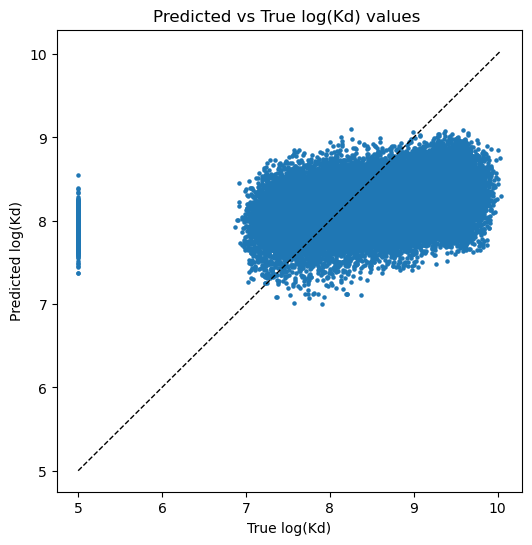

R2: -0.21179851427874463, Spearman: 0.314698672001299, MSE: 0.6890650539824086


In [52]:
# sampled_index =  np.random.choice(np.arange(isolated_rbd_bloom.shape[0]), 1000, replace=False)
r2, spearman, mse = evaluate_model(model, isolated_rbd_desai, kd_ace_desai, kd_scaler=scaler)

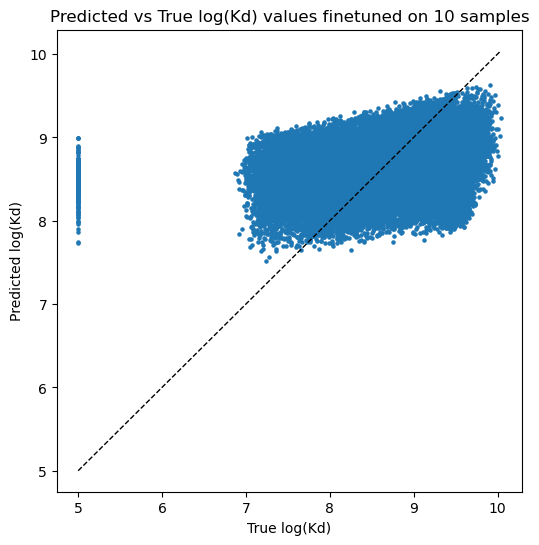

R2: 0.021437959865057366, Spearman: 0.22269912107767745, MSE: 0.5563726241315462


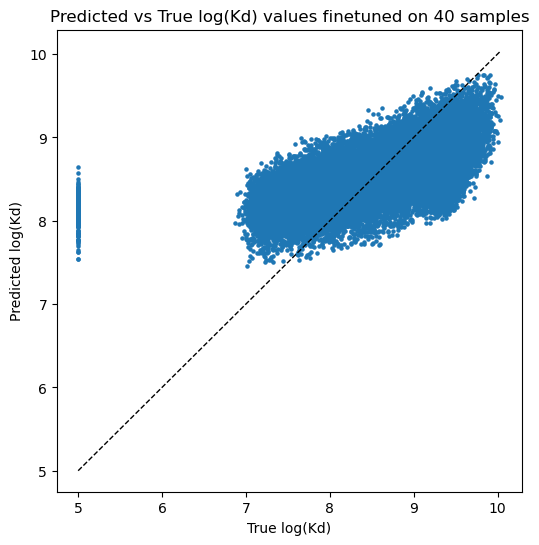

R2: 0.3854972494856841, Spearman: 0.6711444984456305, MSE: 0.34947544500547717


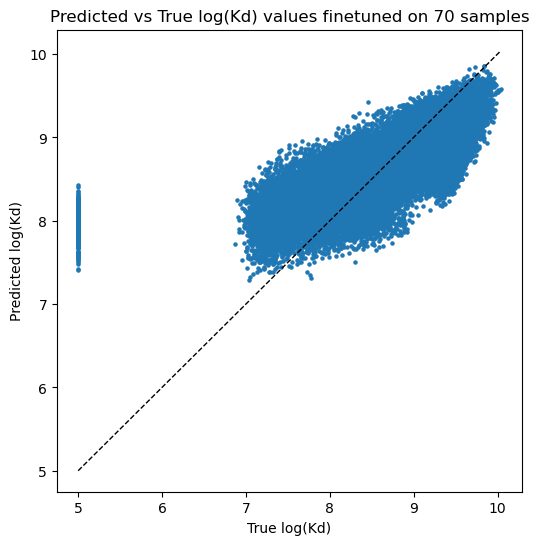

R2: 0.5577474865648772, Spearman: 0.8094331164428562, MSE: 0.2513832898348091


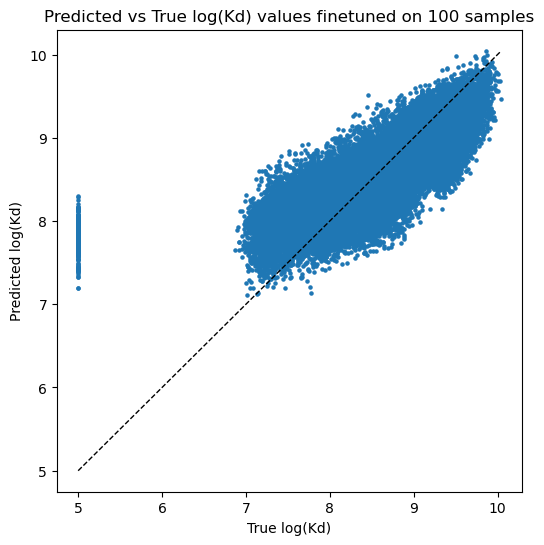

R2: 0.6383356119901404, Spearman: 0.8485815444063857, MSE: 0.20555870543562052


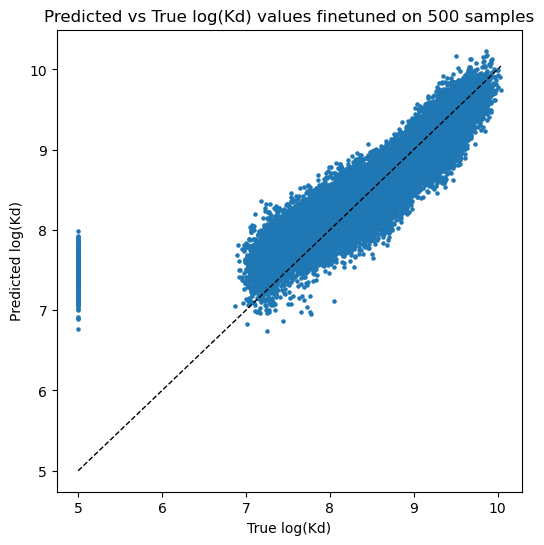

R2: 0.8194164012133363, Spearman: 0.9448049751244365, MSE: 0.10290803720583915


In [46]:
# retrain on desai data
samples = [10, 40, 70, 100, 500]

for sample in samples:
    X_train, X_test, y_train, y_test = train_test_split(isolated_rbd_desai, kd_ace_desai, train_size=sample, test_size=None, random_state=42)
    model_finetuned = fine_tune(model, X_train, scaler.transform(y_train.reshape(-1, 1)).reshape(-1))
    r2, spearman, mse = evaluate_model(model_finetuned, X_test, y_test, kd_scaler=scaler, title=f"finetuned on {sample} samples")


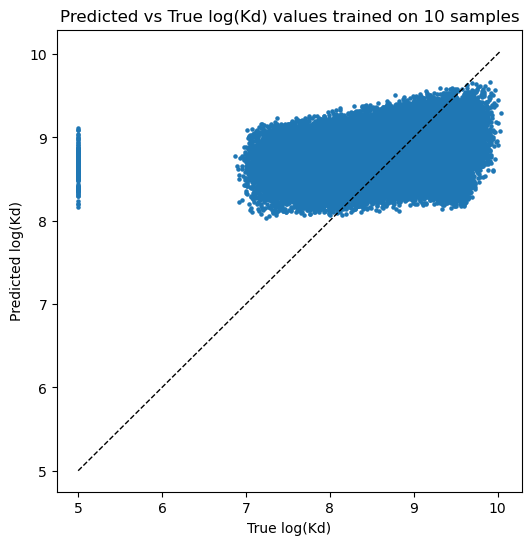

R2: 0.002061529527583539, Spearman: 0.2034641342805654, MSE: 0.5673893148992321


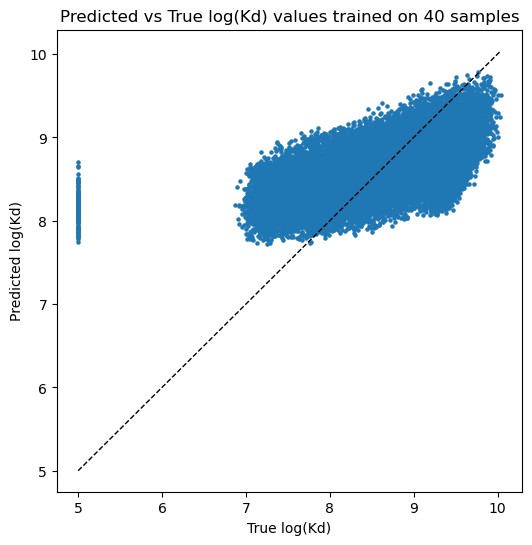

R2: 0.35246144661659207, Spearman: 0.6315526651770491, MSE: 0.36826332170599035


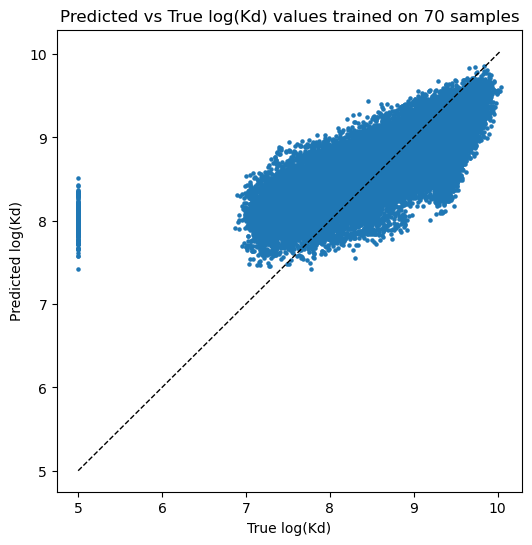

R2: 0.5249708126060684, Spearman: 0.7919872959141022, MSE: 0.270014067228496


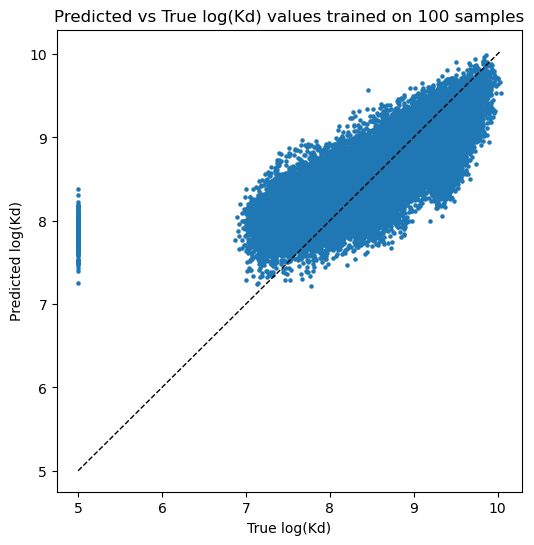

R2: 0.6083794069749973, Spearman: 0.8303370751174054, MSE: 0.2225848736922226


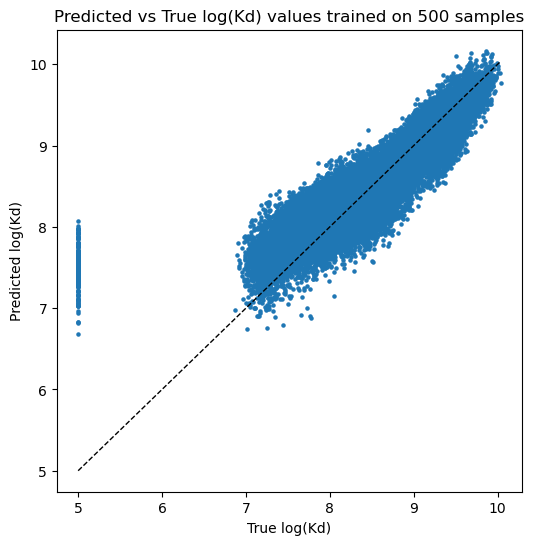

R2: 0.8137399010233624, Spearman: 0.9427289827198099, MSE: 0.10614286858960666


In [49]:
# Compare to trained on desai data only
for sample in samples:
    X_train, X_test, y_train, y_test = train_test_split(isolated_rbd_desai, kd_ace_desai, train_size=sample, test_size=None, random_state=42)
    model_desai, scaler_desai = get_trained_model(SVR, X_train, y_train, 42, {})
    r2, spearman, mse = evaluate_model(model_desai, X_test, y_test, kd_scaler=scaler_desai, title=f"trained on {sample} samples")